<a href="https://colab.research.google.com/github/TeachingTextMining/TextClassification/blob/main/05-SA-Ensemble/05-SA-Ensemble-Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de textos mediante combinación de clasificadores

La clasificación de textos consiste en, dado un texto, asignarle una entre varias categorías. Algunos ejemplos de esta tarea son:

- dado un tweet, categorizar su connotación como positiva, negativa o neutra.
- dado un post de Facebook, clasificarlo como portador de un lenguaje ofensivo o no.  

En la actividad exploraremos cómo implementar la técnica de **stacking** para combinar modelos y su aplicación para clasificar reviews de [IMDB](https://www.imdb.com/) sobre películas en las categorías \[$positive$, $negative$\]. Esta consiste en entrenar un modelo que realiza la clasificación a partir de las predicciones obtenidas por otros clasificadores, como ilustra la figura.

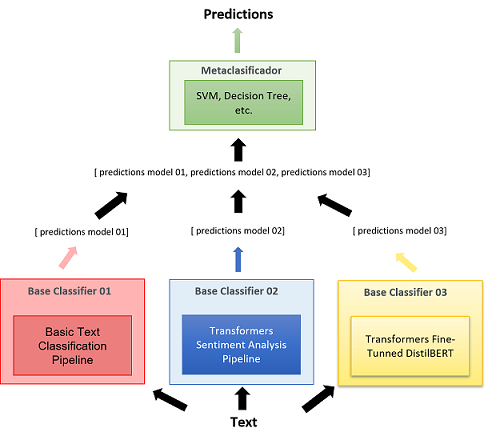

Concretamente combinaremos un clasificador que implementa un pipeline básico para clasificar textos, un modelo pre-entrenado incluido en la librería [Transformers](https://huggingface.co/transformers/) y un clasificador también basado Transformers entrenado específicamente para esta tarea.

Puede encontrar más información sobre los datos utilizados en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) y en [Large Movie Review Datase](http://ai.stanford.edu/~amaas/data/sentiment/).


**Instrucciones:**

- siga las indicaciones y comentarios en cada apartado.


**Después de esta actividad nos habremos familiarizado con:**
- cómo combinar varios modelos para obtener un clasificador más robusto mediante **stacking**.

- cómo construir un pipeline para la clasificación de textos utilizando [scikit-learn](https://scikit-learn.org/stable/).


- cómo instanciar un pipeline para la clasificación de textos utilizando la librería Transformers.

**Requerimientos**
- python 3.6.12 - 3.8
- tensorflow==2.3.0
- transformers==4.2.1
- pandas==1.1.5
- plotly==4.13.0
- tqdm==4.56.0
- scikit-learn==0.24.0

<a name="sec:setup"></a>
### Instalación de librerías e importación de dependencias.

Para comenzar, es preciso instalar las dependencias, realizar los imports necesarios y definir algunas funciones auxiliares.

Ejecute las siguientes casillas prestando atención a las instrucciones adicionales en los comentarios.

In [ ]:
# instalar librerías. Esta casilla es últil por ejemplo si se ejecuta el cuaderno en Google Colab
# Note que existen otras dependencias como tensorflow, etc. que en este caso se encontrarían ya instaladas
%%capture
# !pip install transformers==4.26.0 tensorflow==2.11 pandas==1.3.5 plotly==5.5.0 scikit-learn==1.0.0

print('Done!')

In [ ]:
# reset environment
%reset -f

# comunes
# para establecer caminos al guardar y leer archivos
import os

#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# para cargar datos y realizar pre-procesamiento básico
import numpy as np
import pandas as pd
from collections import Counter

# para evaluar los modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

# para guardar el modelo
import pickle

# Modelo 01
# para pre-procesamiento del texto y extraer característicass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import EnglishStemmer
from sklearn import preprocessing

# para construir pipelines
from sklearn.pipeline import Pipeline

# algoritmos de clasificación
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Modelo 02
# algoritmos de clasificación, tokenizadores, etc.
from transformers import TextClassificationPipeline, DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers.tokenization_utils import TruncationStrategy

# Modelo 03
import tensorflow as tf
from transformers.modeling_tf_utils import keras

# algoritmos de clasificación, tokenizadores, etc.
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig, TextClassificationPipeline

print('Done!')

In [ ]:
# función auxiliar para realizar predicciones con el modelo 1
def predict_model01(model, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  scores = None
  labels = model.predict(data)

  if hasattr(model, 'predict_proba'):
    scores = model.predict_proba(data)

  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  res = {f'scores_{pref}_{cls.lower()}':score for cls, score in zip(model.classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))

  return res


# función auxiliar para realizar predicciones con el modelo 2
def predict_model02(model, cfg, data, batch_size=128, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  size = len(data)
  res_dic = {}

  for i in tqdm(range(0, size, batch_size)):
      batch_text = data[i:i+batch_size]
      results = model(batch_text, truncation=cfg['truncation'])
      # formatear la salida que para cada instancia es una lista tipo con un diccionario para cada clase, con llaves label, score.
      # por ejemplo, para tres clases [{'label':'NEUTRAL', 'score':0.5}, {'label':'NEGATIVE', 'score':0.1}, {'label':'POSITIVE', 'score':0.4}]
      for inst in results:
        for cat in inst:
          cn = f'scores_{pref}_{cat["label"].lower()}'
          if cn in res_dic.keys():
            res_dic[cn].append(cat['score'])
          else:
            res_dic[cn] = list([cat['score']])

  res = pd.DataFrame(res_dic, columns=sorted(list(res_dic.keys())))
  res[f'labels_{pref}'] = res.idxmax(axis=1).apply(lambda n: n.split('_')[2])  # label = categoría con mayor probabilidad
  res = res.reindex(columns=sorted(res.columns))
  return res


# función auxiliar para obtener tensores de entrada al modelo 3 a partir del texto
def get_model_inputs03(cfg, data):
    # obtener ids y máscaras para el conjunto de entrenamiento
    # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato,
    encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])

    # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
    # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf')
    # son utilizados como llaves en los diccionarios que representan las entradas al modelo
    inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
            }
    return inputs

# función auxiliar para realizar predicciones con el modelo 3
def predict_model03(model, cfg, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs03(cfg, data)
  scores = model.predict(inputs)['logits']  # la salida de este modelo es TFSequenceClassifierOutput, debe tomarse el valor asociado a la llave 'logits'

  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
  fig_roc = None
  if y_score is not None:
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    fig_roc = px.area(
        x=fpr, y=tpr,
        title = f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
        width=400, height=400
    )
    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
    fig_roc.update_xaxes(constrain='domain')

    fig_roc.show()

print('Done!')

### Carga de datos y análisis exploratorio

El primer paso consiste en obtener los datos relacionados con nuestra tarea dejándolos en el formato adecuado.  Existen diferentes opciones, entre estas:

- montar nuestra partición de Google Drive y leer un fichero desde esta.

- leer los datos desde un fichero en una carpeta local.

- leer los datos directamente de un URL.

En este caso, se encuentran en un fichero separado por comas con la siguiente estructura:

| Phrase | Sentiment|
| ------ | ------ |
| This movie is really not all that bad...    | positive |


Ejecute la siguiente casilla para leer los datos.

In [ ]:
# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
#path = './sample_data/ejemplo_review_train.csv'

# descomente la siguiente línea para leer datos desde un URL
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/05-SA-Ensemble/sample_data/ejemplo_review_train.csv'

# leer los datos
data = pd.read_csv(path, sep=',')

print('Done!')

Una vez leídos los datos, ejecute la siguiente casilla para construir una gráfica que muestra la distribución de clases en el corpus.

In [ ]:
text_col = 'Phrase'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col])
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Finalmente, ejecute la siguiente casilla para crear los conjuntos de entrenamiento y validación que se utilizarán para entrenar y validar los modelos.

In [ ]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0  # fijar random_state para reproducibilidad
train, val = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)

print('Done!')

### Entrenamiento de los clasificadores base

#### Modelo 1: Pipeline para clasificación de textos
El primer modelo será un pipeline básico para la clasificación de textos.
Ejecute la siguiente casilla para definir algunas variables y funciones auxiliares, instanciar el modelo y entrenarlo. Preste atención a las explicaciones dadas en los comentarios. Por simplicidad, no guardaremos el modelo.

In [ ]:
# listado de stopwords
stop_words=['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves',
            'he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their',
            'theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are',
            'was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an',
            'the','and','but','if','or','because','as','until','while','of','at','by','for','with','about',
            'against','between','into','through','during','before','after','above','below','to','from','up',
            'down','in','out','on','off','over','under','again','further','then','once','here','there','when',
            'where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor',
            'not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'ever']

# función auxiliar. Se utiliza al obtener la representación mediante TF-IDF del texto pues en este caso
# se removerán las stop_words y se considerarán los "stem" en lugar de las palabras
def english_stemmer(sentence):
  stemmer = EnglishStemmer()
  analyzer = CountVectorizer(binary=False, analyzer='word', stop_words=stop_words, ngram_range=(1, 1)).build_analyzer()
  return (stemmer.stem(word) for word in analyzer(sentence))

# crear el pipeline
model01 = Pipeline([
            ('dataVect', CountVectorizer(analyzer=english_stemmer)),
            ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
            ('classifier', SVC(probability=True))
          ])

# entrenar el modelo
model01.fit(train[text_col], train[class_col])

print('Done!')

#### Modelo 2: Modelo pre-entrenado para análsis de sentimientos basado en Transformers

El segundo modelo considerado es un pipeline para la clasificación de textos incluido en la librería Transformers.

Ejecute la siguiente casilla para instanciar el pipeline. Note que no es necesario entrenar pues este paso ya se ha realizado por Transformers. Por simplicidad, no guardaremos el modelo.

In [ ]:
# configuraciones
cfg02 = {}
cfg02['framework'] = 'tf'
cfg02['task'] = 'sentiment-analysis'
cfg02['trained_model_name'] = 'distilbert-base-uncased-finetuned-sst-2-english'
cfg02['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg02['truncation'] = TruncationStrategy.ONLY_FIRST

# cargar el tokenizador, disponible en Transformers. Establecer model_max_length para cuando el tokenizador sea llamado, trunque automáticamente.
cfg02['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg02['trained_model_name'] , model_max_length=cfg02['max_length'])

# cargar el modelo, disponible en Transformers
cfg02['transformer'] = TFDistilBertForSequenceClassification.from_pretrained(cfg02['trained_model_name'])

# instanciar el pipeline para la clasificación de textos
model02 = TextClassificationPipeline(model=cfg02['transformer'], tokenizer=cfg02['tokenizer'], framework=cfg02['framework'], task=cfg02['task'], top_k=None)

print('Done!')

#### Modelo 3: Fine-tunned Transformer (DistilBERT)

El tercer y último clasificador será un modelo basado en Transformers, entrenado específicamente en nuestros datos. En este caso, es necesario tokenizar y convertir a tensores los datos de acuerdo con los requisitos de Transformers.

Ejecute las siguientes casillas para instanciar el modelo, pre-procesar los datos y entrenar el modelo. Preste atención a las explicaciónes dadas en los comentarios. Por simplicidad, no guardaremos el modelo.

In [ ]:
# configuraciones
cfg03 = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg03['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg03['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg03['transformer_model_name'] = 'distilbert-base-uncased'
cfg03['num_labels'] = 1  # cambiar este número según el número de clases

print('Done!')

Configuración del modelo

In [ ]:
# configuraciones
config = DistilBertConfig(num_labels=cfg03['num_labels'], seq_classif_dropout=0.5)

# cargar el modelo pre-entrenado disponible en Transformers
model03 = TFDistilBertForSequenceClassification.from_pretrained(cfg03['transformer_model_name'], config=config)

# finalizar configuración del modelo
# se sugiere revisar documentación para más detalles sobre los diferentes hiper-parámetros
optimizer = keras.optimizers.Adam(learning_rate=5e-5)

# definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
# y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# compilar el modelo, indicando otras métricas que se desee monitorear
# La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
model03.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy'])

# imprimir sumario del modelo
model03.summary()

print('Done!')

##### Instanciar tokenizador, etc.

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg03['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg03['transformer_model_name'] )

# instanciar y entrenar LabelBinarizer
cfg03['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

##### Pre-procesamiento

In [ ]:
# entrenar LabelBinarizer
cfg03['label_binarizer'].fit(train[class_col])

# obtener codificación one-hot
train_blabels = cfg03['label_binarizer'].transform(train[class_col])
val_blabes = cfg03['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs03(cfg03, train[text_col].to_list())
val_inputs = get_model_inputs03(cfg03, val[text_col].to_list())

print('Done!')

##### Entrenamiento del modelo

In [ ]:
# configuraciones
epochs_max = 1
batch_size = 16

model03.fit(train_inputs, y=train_blabels_t, initial_epoch=0, epochs=epochs_max, batch_size=batch_size)

print('Done!')

### Construcción del ensemble

Como el stack de clasificadores se construirá de forma manual, es preciso realizar los siguientes pasos:

- utilizar los modelos base para predecir las instancias del conjunto de entrenamiento. En este caso en lugar de la categoría, recuperaremos su probabilidad o scores calculado por el clasificador. Notar que cuando se trata de probabilidades, tendremos información redundante ya que la suma de las probabilidades para cada clase es 1.

- combinar las predicciones de cada modelo para obtener el conjunto de entrenamiento del metaclasificador.

- entrenar el metaclasificador.

#### Obtener predicciones de los modelos base

Para entrenar el metaclasificador, utilizaremos la partición **train** previamente creada. Recordemos que hemos reservado la partición **eval** para evaluar cada modelo y compararlo respecto al metaclasificador.

Ejecute las siguientes casillas para definir algunas funciones auxiliares y realizar la predicción del conjunto de entrenamiento.


##### Utilizar modelos bases para predecir el conjunto de entrenamiento

In [ ]:
# definir conjunto sobre el que se trabajará.
data = train

In [ ]:
# predicciones modelo 1
m01_pred = predict_model01(model01, data[text_col].to_list(), pref='m01')

print(f'\n {m01_pred.head(5)}')
print('Done!')

In [ ]:
# predicciones modelo 2
m02_pred = predict_model02(model02, cfg02, data[text_col].to_list(), batch_size=128, pref='m02')

print(f'\n {m02_pred.head(5)}')
print('Done!')

In [ ]:
# predicciones modelo 3
m03_pred = predict_model03(model03, cfg03, data[text_col].to_list(), pref='m03')

print(f'\n {m03_pred.head(5)}')
print('Done!')

Finalmente se combinarán las salidas de los modelos base. Notar que debe prestarse atención a organizar los datos según el algoritmo que los vaya a utilizar. En este caso, una matriz con una fila por cada instancia y una columna por cada variable.


In [ ]:
# combinar predicciones de los clasificadores base
cmb = pd.concat([m01_pred, m02_pred, m03_pred], axis=1)
cmb.drop(columns=['labels_m01', 'labels_m02', 'labels_m03'], inplace=True)

# separar entradas y salidas esperadas para satisfacer formato requerido por scikit-learn
# además, consideraremos solo los scores positivos para los modelos 1 y 2, y el score del modelo 3,
# pero es posible utilizar también las otras salidas de los modelos base.
cmb = cmb.loc[:,['scores_m01_positive', 'scores_m02_positive', 'scores_m03']]
X = cmb.values
y = data[class_col] # !ATENCIÓN! el orden de las instancias debe ser el mismo en X e y

print(cmb.head(5))
print('Done!')

#### Instanciar y entrenar metaclasificador

Finalmente, podemos utilizar el nuevo conjunto de entrenamiento formado por la combinación de los predictores base para entrenar el metaclasificador. En este caso, utilizaremos la implementación de árboles de decisión en [scikit-learn](https://scikit-learn.org/stable/).


In [ ]:
# instanciar el clasificador
classifier = DecisionTreeClassifier(criterion='entropy', random_state=seed)

# entrenar el clasificador
classifier.fit(X, y)

# graficar el árbol
fig = plt.figure(figsize=(20,20))

plot_tree(classifier, feature_names=cmb.columns, class_names=classifier.classes_, filled=True, impurity=False)
plt.show()

print('Done!')

### Comparando resultados

Entrenados todos los modelos, realizaremos una comparación entre los resultados que alcanzan los modelos base y el ensemble. Para esto, utilizaremos la porción **val**.

Debemos recordar que para aplicar este cuaderno a otros datos probablemente deba adecuar los nombres de las columnas. Además, al llamar a la función que evalúa el modelo se debe tener en cuenta que el parámetro *y_scores* solo considera las probabilidades de la clase *pos_label*. La implementación actual asume que se trata de un problema de clasificación binaria.


In [ ]:
# definir conjunto sobre el que se trabajará.
data = val

#### Evaluación Modelo 1

In [ ]:
# predecir y evaluar conjunto de validación con el modelo 1
true_labels = data[class_col]

m01_pred = predict_model01(model01, data[text_col].to_list(), pref='m01')

evaluate_model(true_labels, m01_pred['labels_m01'], m01_pred['scores_m01_positive'], 'positive')

print('Done!')

#### Evaluación Modelo 2

In [ ]:
# predecir y evaluar conjunto de validación con el modelo 2
true_labels = data[class_col]

m02_pred = predict_model02(model02, cfg02, data[text_col].to_list(), batch_size=128, pref='m02')

evaluate_model(true_labels, m02_pred['labels_m02'], m02_pred['scores_m02_positive'], 'positive')

print('Done!')

#### Evaluación Modelo 3

In [ ]:
# predecir y evaluar conjunto de validación con el modelo 3
true_labels = data[class_col]

m03_pred = predict_model03(model03, cfg03, data[text_col].to_list(), pref='m03')

evaluate_model(true_labels, m03_pred['labels_m03'])  # notar que en este caso se no suministran los scores

print('Done!')

#### Evaluación Ensemble

In [ ]:
# combinar predicciones de los clasificadores base
cmb = pd.concat([m01_pred, m02_pred, m03_pred], axis=1)
cmb.drop(columns=['labels_m01', 'labels_m02', 'labels_m03'], inplace=True)

# separar entradas y salidas esperadas para satisfacer formato requerido por scikit-learn
# además, consideraremos solo los scores positivos para los modelos 1 y 2, y el score del modelo 3,
# pero es posible utilizar también las otras salidas de los modelos base.
cmb = cmb.loc[:,['scores_m01_positive', 'scores_m02_positive', 'scores_m03']]
X = cmb.values
y = data[class_col]  # !ATENCIÓN! el orden de las instancias debe ser el mismo en X e y

print(cmb.head(5))
print('Done!')

In [ ]:
# predecir y evaluar conjunto de validación con el modelo 3
true_labels = y

mc_pred = predict_model01(classifier, X, pref='mc')

evaluate_model(true_labels, mc_pred['labels_mc'], mc_pred['scores_mc_positive'], pos_label='positive')

print('Done!')

### Conclusiones

En la actividad se ha construido un **stack** de clasificadores de forma manual para ilustrar las ideas fundamentales de esta estrategia para combinar clasificadores. No obstante, existen diferentes implementaciones disponibles, por ejemplo [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html).

Para detalles sobre cada uno de los modelos base utilizados o si desea guardarlos una vez entrenados para su posterior uso, puede ver los correspondientes cuadernos:

- [01-SA-Pipeline](https://github.com/TeachingTextMining/TextClassification/tree/main/01-SA-Pipeline)

- [02-SA-Transformers-Basic](https://github.com/TeachingTextMining/TextClassification/tree/main/02-SA-Transformers-Basic)

- [03-SA-Transformers-Training-FineTuning](https://github.com/TeachingTextMining/TextClassification/tree/main/03-SA-Transformers-Training-FineTuning)
